# Discussion of the K-distributed Sea Clutter Simulation for the MKCF-TBD in TAES2021.

To answer the peer researcher's question, I reviewed the code of 'K_distributed_SeaClutter_Simulation_20210919.py' (https://github.com/joeyee/MKCF-TBD/blob/main/K_distributed_SeaClutter_Simulation_20210919.py) in September of 2025. Here, I list some of the little differences between MKCF-TBD's implementation and three pioneers' work [ToughJPD1999, WardBook2006, BrekkeIJOE2010] for open discussion. If you have different opionions, please contact me through email or discussion board (https://github.com/joeyee/MKCF-TBD/discussions).




## Question: 
There is no scale parameter $b$ for the gammma probability density function (pdf) 
$p(t; v, b) = \frac{t^{v-1}e^{-t/b}}{\Gamma(v) b^v} $ in the code? 
Does it mean that it is set to be 1?

Answer: Yes. We set the $b=1$ for standardized gamma distribution like in the [WardBook2006, BrekkeIJOE2010]. In Brekke's papber, the scale parameter is set as $b/2$. In the Memoryless NonLinear Transform (MNLT) mapping between $x$ and $\eta$, the cumulative distribution of the Gamma with $b$, $F_b(x; v, b)$, can be computed directly through the standardized gamma's cumulative distribution $F_1(x/b; v, 1)$. Following are the derivations:

$F_b(x; v, b) = P(t\leq x) = \int_{-\infty}^{x}p(t; v, b)dt = \int_{-\infty}^{x}\frac{t^{v-1}e^{-t/b}}{\Gamma(v) b^v}dt \quad$ (1)

Let $u = t/b$, and replace $t$ with $u$ for the equation (1), then we have:

$F_b(x; v, b) = \int_{-\infty}^{x/b}\frac{u^{v-1}e^{-u}}{\Gamma(v)}du = F_1(x/b; v, 1)\quad$ (2)



## Errata 1 coefficient in the erfc function. 
Memoryless NonLinear Transform (MNLT) mapping ($x\to \eta(x)$) between standard Gaussian Process (a sample $x$) and Gamma Process ($\eta(x)$). We noticed that [BrekkeIJOE2010] and [WardBook2006] [ToughJPD1999] using a little different integration term to compute the MNLT mapping.
The integration term in Brekke's paper is :

$ \int_{-\infty}^{\infty} \, \exp(-\xi^2) H_n(\xi) \, \text{GammaCDF}^{-1}\left( 1-\frac{\text{erfc}(\xi)}{2} \right)d\xi, \quad$  (3) 

while in Ward and Tough's paper, it is:

$\int_{-\infty}^{\infty}dx \, \exp(-x^2) H_n(x) Q_{\text{dist}}\left( \frac{\text{erfc}(x)}{2} \right). \quad$ (4)

In scipy's lib., the $x$ and $\eta$ are in the low bounder of the integration, therefore we choose the Brekke's integration term.

In MKCF-TBD, we had used the $x/\sqrt{2}$ in the erfc function (follow eq. (26) of Brekke's paper) in a wrong way, which didn't consider the mulitplication of two correlated distributions. In eq.(27) of Brekke's paper, it used $\text{erfc}(x)/2$ for the integration term.

Given $v=5$, coefficients in mkcf_tbd are close to v=1.3 in Ward's book. Lower v gets more asymmetric shape in pdf. The background texture is more spiky.


In [ ]:
import numpy as np
from scipy.stats import gamma
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
from numpy.fft import fft, fftshift, ifft, ifftshift
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as ss

def mnlt(x, v):
    r'''
    memoryless non-linear transform based on eq(26) of Bekker_IJOE2010
    Note the scipy.special function gammaincinv already divide the factor 1/Tau(v)
    :return:
    '''
    nlx = 1 - ss.erfc(x)/2
    eta_x = ss.gammaincinv(v, nlx)
    return eta_x

def mnlt_mkcf(x, v):
    '''
    In MKCF-TBD, we have used the x/np.sqrt(2) in the erfc function. 
    This is wrong which didn't consider the mulitplicatino of two correlated distribution. 
    '''
    nlx = 1 - ss.erfc(x/np.sqrt(2))/2
    eta_x = ss.gammaincinv(v, nlx)
    return eta_x

def mnlt_error_effection(v):
    '''verify the cumulative equality between Brekke's and Ward's MNLT mapping.'''
    x = np.linspace(-4, 4, 1000)
    eta = mnlt(x, v)
    eta_mkcf = mnlt_mkcf(x, v)
    
    #Approximately, R_{\Gamma} and R_{G} are linear related.
    #R_{\Gamma} = eta_mean^2 + eta_var*R_{G} 
    coefficients_book = [eta.mean()**2, np.mean(eta**2) - eta.mean()**2]
    coefficients_mkcf = [eta_mkcf.mean()**2, np.mean(eta_mkcf**2) - eta_mkcf.mean()**2]
    print('v=%f, coefficients_book=%s, coefficients_mkcf=%s' % (v, coefficients_book, coefficients_mkcf))
    # print(coefficients_book)
    # print(coefficients_mkcf)


mnlt_error_effection(v=1.3)
mnlt_error_effection(v=5)

#Given v=5, coefficients in mkcf_tbd are close to v=1.3 in Ward's book. Lower v gets more asymmetric shape in pdf.



v=1.300000, coefficients_book=[16.515255026565715, 30.41997103560342], coefficients_mkcf=[6.6856279397528295, 10.18165188217673]
v=5.000000, coefficients_book=[65.10636709614668, 70.73568094233765], coefficients_mkcf=[41.004669382914074, 30.034622824090462]


## Errate 2 high order coefficients. 
coefficients verification:
the power series equation between the autocorrelation functions (ACF) $R_{\Gamma}(t)$  and $R_{G}(t)$ for the two random process is:
$R_{\Gamma}(t) = \langle \eta(0)\eta(t) \rangle =  \frac{1}{\pi}\sum_{n=0}^{\infty} \frac{R_G(t)^n}{2^n n!}  \left( \int_{-\infty}^{\infty}dx \, \exp(-x^2) H_n(x) Q_{\text{dist}}\left( \frac{\text{erfc}(x)}{2} \right)\right)^2 \quad$ (5)

$R_{\Gamma}(t) = \sum_{n=0}^{\infty} \alpha_n R_G(t)^n. \quad$ (6)

In Ward's book, the coefficients for $v=1$ are recorded and said that as $v$ increase, the high order term only takes 1% energy (when $v > 4.5$). 

$R_{\Gamma}(t) \approx 0.000017R_G(t)^5 + 0.00013R_G(t)^4 + 0.0067R_G(t)^3 + 0.177R_G(t)^2 + 0.816R_G(t) + 1 \quad$ (6)


Here is an errata in the function of hermite_polynomials(x,n) for the order n=5, the constant 120 should multiply $x$.
In MKCF-TBD, we only use the order of 2, this error not affects the results.




In [31]:
import math
def hermite_polynomials(x, n):
    '''
    compute the hermite polynomials with respect to x.
    :param x: variable
    :param n: order
    :return: H_n(x) = (-1)^n exp(x^2) d^n/dx^n exp(-x^2), this can be computed by the symbol calculus of py
    import sympy as sym
    x = sym.Symbol('x')
    (-1)^n*sym.exp(x**2)*sym.diff(sym.exp(-x**2), x, n)
    '''
    if n>5:
        print('Order greater than 5 is NOT defined!!! Limit n to 5')
        n = 5
    if n==5:
        #Hn = 32*(x**5)-160*(x**3) + 120 # in mkcf-tbd's 20210919 version.
        Hn = 32*(x**5)-160*(x**3) + 120*x # in 20210919's version, I lost a x for 120. Luckly, it's not affect the results, since I only takes the high order of 2.
    if n==4:
        Hn = 16*(x**4) - 48*(x**2) + 12
    if n==3:
        Hn = 8*(x**3) - 12*x
    if n==2:
        Hn = 4*(x**2) - 2
    if n==1:
        Hn = 2*x
    if n==0:
        Hn = 1
    return Hn

def coeff_acf_polyn(x, gamma_cdf_inv, max_order=5):
    '''
    Compute the coefficients of the polynomials with respect to R_G(\tau),
    based on the relation between the ACFs of two Process (Gaussian and Gamma process).
    alpha_n R_G(\tau)^n + .... + alpha_1 R_G(\tau) + alpha_0 - R_T(\tau)
    :param x: x is the samples from a zero-mean unit-variance Gaussian distribution
    :param n:
    :return:
    '''
    coeffs = []
    #for n in range(2, -1, -1): #from 5 to 0
    for n in range(max_order,-1,-1):
        factor = 1/(np.pi*math.factorial(n)*2**n)
        Hn     = hermite_polynomials(x, n)
        alpha_n= np.sum((np.exp(-x**2)*Hn*gamma_cdf_inv))**2
        alpha_n= factor*alpha_n
        coeffs.append(alpha_n)
    coeffs = np.array(coeffs) / coeffs[-1]
    return coeffs

#verify the coeeficients for v=1 with the maximum order of n=5
v = 1
x = np.linspace(-4, 4, 1000)
eta = mnlt(x, v)
coeffs = coeff_acf_polyn(x, eta, max_order=5)
print(coeffs) # compare the coeffs with the upper eq. (6)


[1.74616303e-05 1.34999645e-04 6.68295003e-03 1.77388035e-01
 8.15764026e-01 1.00000000e+00]


## Verification 1: Mapping between $R_{\Gamma}$ and $R_G$.

Mapping between $R_{\gamma}$ and $R_{G}$, Fig. 5 in [ToughJPD1999] for different $v$. 
Here the normalized $R_{\Gamma} = (R_{\Gamma}-1)*v$, which is not the same as the $R_{\Gamma} = (R_{\Gamma}-v^2)/v$ in  Tough's paper.

Lowest $v$ becomes nonlinear when $R_{G}<0$. Same figure in Fig4.2 of the ward_book_2006(chinese version) or Fig5.2 (english version).


<>:26: SyntaxWarning: invalid escape sequence '\G'
<>:26: SyntaxWarning: invalid escape sequence '\G'
/var/folders/t1/yp7tdz2n7f39yvhd6tnpwlm80000gn/T/ipykernel_36238/1450796705.py:26: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('$(R_{\Gamma}(t)-1)*v$')


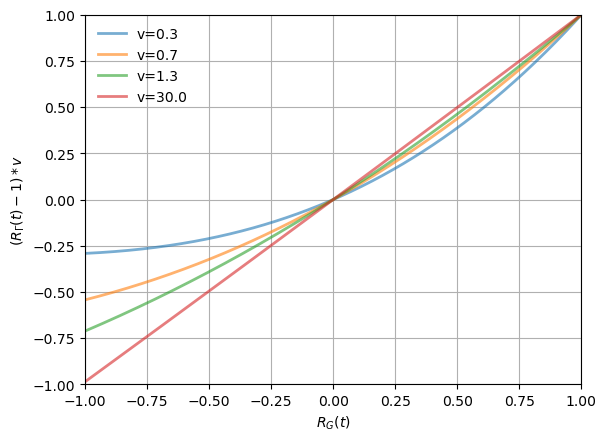

In [13]:
def verify_RtRg_nonliear_mapping():
    '''
    Verify the nonlinear mapping between the Gaussian process ACF and the Gamma process ACF.
    Fig4.2 of the ward_book_2006(chinese version).
    or Fig5.2 of the ward_book_2006(english version),
    or Fig 5 of the Tough_JPD_1999 papper.
    Check the non-linear mapping (R_G(t) vs R_T(t), especially when R_G(t)<0), 
    when the shape parameter of the Gamma distribution is different.
    :return:
    '''
    x = np.linspace(-4, 4, 2048)
    for v in [0.3, 0.7, 1.3, 30]:
        eta = mnlt(x, v)
        coeffs = coeff_acf_polyn(x, eta, max_order=5)
        gaussian_acf = np.linspace(-1,1,1024)
        assert(len(coeffs)==6) # highest order of the polynomial is 2.
        gamma_acf = coeffs[0]*gaussian_acf**5+coeffs[1]*gaussian_acf**4 \
                +coeffs[2]*gaussian_acf**3+coeffs[3]*gaussian_acf**2 \
                +coeffs[4]*gaussian_acf+coeffs[5]
        #norm_gamma_acf = (gamma_acf - v**2)/v # not the same as fig4.2 or the Fig5 in Tough_JPD1999 papper.
        #note (gamma_acf-1)*v is more similar to fig4.2  than norm_gamma_acf in the plot.
        plt.plot(gaussian_acf, (gamma_acf-1)*v,  '-', lw=2, alpha=0.6, label='v=%.1f' % v)
        plt.grid(True)

    plt.xlabel('$R_G(t)$')
    plt.ylabel('$(R_{\Gamma}(t)-1)*v$')
    plt.xlim(-1,1)
    plt.ylim(-1, 1)
    plt.legend(loc='best', frameon=False)
    plt.show()
verify_RtRg_nonliear_mapping()

## Verification 2:  single point gamma distribution
Verify the single point gamma and controlled acf,  
Fig.4.3 in ward_2006_book(chinese version, pp.87),
or Fig.5.3 english version, pp.162,
Fig.6 of the Tough_JPD_1999 papper.

The gamma process generated by MNLT are a sequence of samples across the time steps. Repeating the sampling procedure, the statiscs in a fixed time step or spatial point should follow the gamma distribution with the shape $v$. Here, we do the verificaiton in 1024 steps (or points), and repeat 2048 times, and check the statistics in a time step.



n=700, fit_alpha=0.56, fit_loc=-0.00, fit_beta=1.64
n=154, fit_alpha=0.65, fit_loc=-0.00, fit_beta=1.56
n=656, fit_alpha=0.63, fit_loc=-0.00, fit_beta=1.64


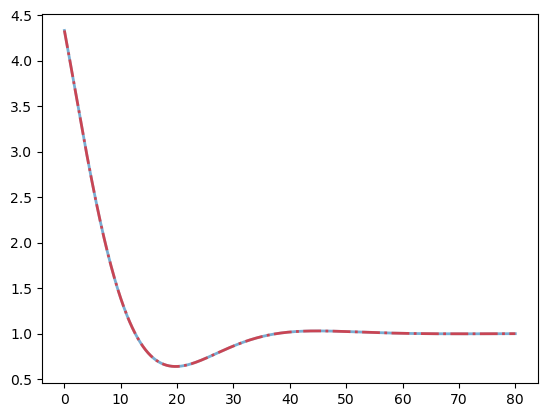

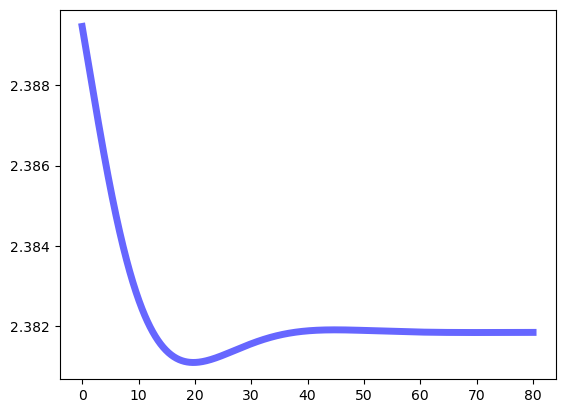

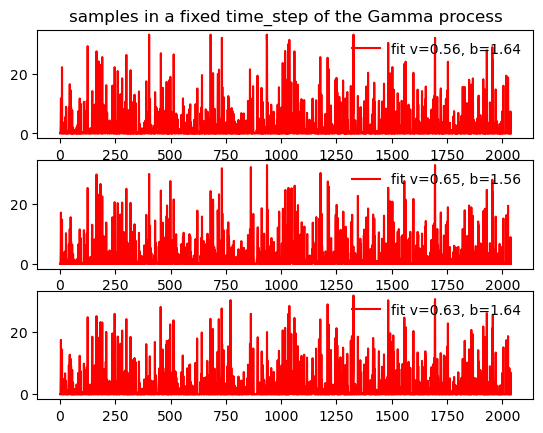

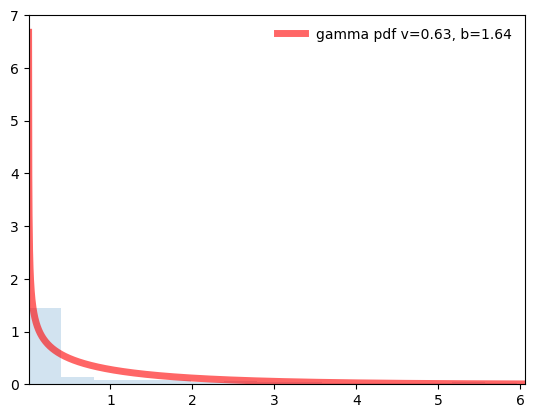

In [30]:
def solve_acf_polyn(gamma_acf, coeff_acf_polyn):
    r'''
    solve the polynomials of Gaussian acf R_G(\tau), given the Gamma acf R_{\Gamma}.
    :param gamma_acf:
    :param coeff_acf_polyn:
    :return:
    '''
    coeffs       = coeff_acf_polyn.copy()
    gaussian_acf = np.zeros(gamma_acf.shape, dtype=complex)

    if len(gamma_acf.shape)==1:
        Nr = len(gamma_acf)
        for r in range(Nr):
            coeffs[-1] = coeff_acf_polyn[-1] - gamma_acf[r]
            gaussian_acf[r] = np.roots(coeffs)[0]  # solve the acf polynomials for each element.

    if len(gamma_acf.shape)==2:
        Nr, Ntheta = gamma_acf.shape[:2]
        for r in range(Nr):
            for theta in range(Ntheta):
                coeffs[-1] = coeff_acf_polyn[-1] - gamma_acf[r, theta]
                gaussian_acf[r, theta] = np.roots(coeffs)[0] # solve the acf polynomials for each element.

    return gaussian_acf

def verify_singlePoint_gamma_and_controlled_acf(v=0.3):
    '''
    Verify the single point gamma in controlled acf,  
    Fig.4.3 in ward_2006_book(chinese version, pp.87),
    or Fig.5.3 english version, pp.162,
    Fig.6 of the Tough_JPD_1999 papper.

    :param v: the shape parameter of the Gamma distribution.
    :return:
    '''
    x = np.linspace(-4, 4, 2048)
    eta = mnlt(x, v)
    coeffs = coeff_acf_polyn(x, eta, max_order=5)

    ts = np.linspace(0,80,1024)

    gamma_acf    = 1 + np.exp(-ts/10)*np.cos(ts/8)/v

    plt.plot(ts, gamma_acf,  '-', lw=2, alpha=0.6, label='v=%.1f' % v)
    gaussian_acf = solve_acf_polyn(gamma_acf, coeffs)


    assert(len(coeffs)==6) # highest order of the polynomial is 5.
    gamma_acf_re = coeffs[0]*gaussian_acf**5+coeffs[1]*gaussian_acf**4 \
            +coeffs[2]*gaussian_acf**3+coeffs[3]*gaussian_acf**2 \
            +coeffs[4]*gaussian_acf+coeffs[5]
    plt.plot(ts, gamma_acf_re,  'r-.', lw=2, alpha=0.6, label='v=%.1f' % v)

    plt.figure()
    plt.plot(ts,gaussian_acf, 'b-', lw=5, alpha=0.6, label='gaussian acf')
    #plt.show()

    time_steps  = 1024
    repeat_nums = 2048

    gamma_time_seq = np.zeros((time_steps,repeat_nums))
    #
    for i in range(repeat_nums):
        Gwn   = np.random.normal(loc=0, scale=1, size=time_steps)#+1j*np.random.normal(loc=0, scale=1, size=1024)
        F_Gw  = fft(Gwn)  # /np.sqrt(f.size)
        # plt.stem(np.abs(F_Gw))
        # plt.show()
        F_Grc = fft(gaussian_acf)
        # plt.figure()
        # plt.stem(np.abs(F_Grc), 'g-')
        # plt.title('Fw of gaussian acf')
        #plt.show()
        # # # correlated Gaussian noise's psd is known as F_Rc
        Gcn = np.real(ifft(F_Gw * np.sqrt(F_Grc)))
        # plt.figure()
        # plt.plot(Gcn, 'b-')
        # plt.title('controlled color Gaussian noise')
        #plt.show()
        Gan = mnlt(Gcn, v=v) #mnlt function is based on eq(26) of Berkker_IJOE2010
        # assert(np.sum(Gan==np.inf))==0,'Gan has inf elements'
        # assert(np.sum(Gan==np.nan))==0,'Gan has nan elements'
        gamma_time_seq[:,i] = Gan #put a sequence samples in a column.
        #print('i=%d, Gan.max()=%f, Gan.min()=%f, Gan.mean()=%f' % (i, Gan.max(), Gan.min(), Gan.mean()))
    fig, axs = plt.subplots(3,1)
    ids = np.random.randint(0, time_steps, 3)
    for i in range(3): # check the statics in a time_step
        samples = gamma_time_seq[ids[i],:]
        
        if i==0: axs[i].set_title('samples in a fixed time_step of the Gamma process')
        #exclude the inf value
        samples = samples[samples!=np.inf]
        fit_alpha, fit_loc, fit_beta = stats.gamma.fit(samples, scale=0.9)
        axs[i].plot(samples, 'r-', label=f'fit v={fit_alpha:.2f}, b={fit_beta:.2f}')
        print(f'n={ids[i]}, fit_alpha={fit_alpha:.2f}, fit_loc={fit_loc:.2f}, fit_beta={fit_beta:.2f}')
        axs[i].legend(loc='best', frameon=False)
    
    fig, ax = plt.subplots()
    x = np.linspace(gamma.ppf(0.01, fit_alpha, scale=fit_beta), gamma.ppf(0.99, fit_alpha, scale=fit_beta), 2048)
    ax.plot(x, gamma.pdf(x, fit_alpha, scale=fit_beta), 'r-', lw=5, alpha=0.6, label=f'gamma pdf v={fit_alpha:.2f}, b={fit_beta:.2f}')

    ax.hist(samples, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
    ax.set_xlim([x[0], x[-1]])
    ax.legend(loc='best', frameon=False)
    plt.show()


verify_singlePoint_gamma_and_controlled_acf(v=0.3)

## Verification 3: Random Gamma Field with $v=5$ and controled acf.

Given the fied size with square w,h = 300,300, gamma shape v=5, generate the gamma random texture for the fig. 4.4 of the Ward's book (chinese version) and Figure 7 of Tough's paper.

Notefication, in MKCF-TBD, we computed the coefficents of the mapping between $R_{\Gamma}$ and $R_{G}$ with random Gaussian samples. While in the Ward's book, it may choose the linear spaced $x$ to compute the coefficients (please check the section Errate 2 high order coefficients).

We noticed that if the intergration uses the random variables from the unit Gaussion (MKCF-TBD's approach), the ampltidue of the simulated K noise is more spiky.

[0.00854515 0.19141219 1.        ]


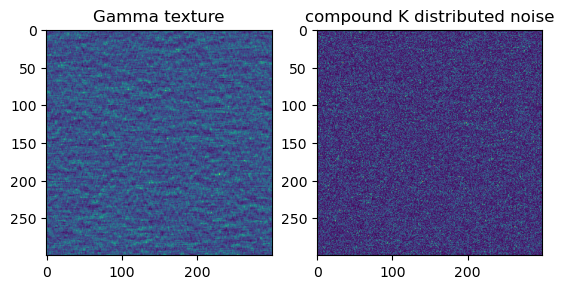

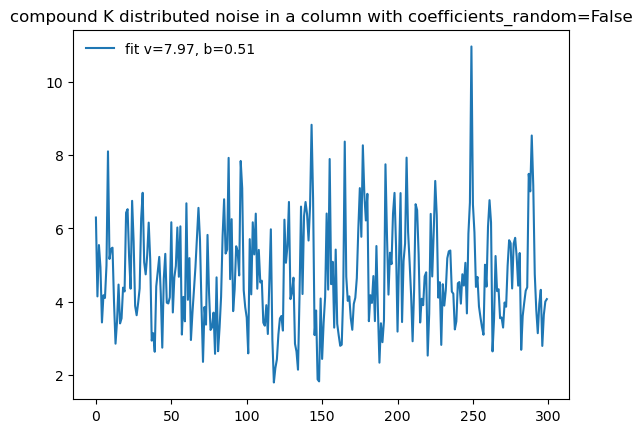

[0.03736824 0.08821982 1.        ]


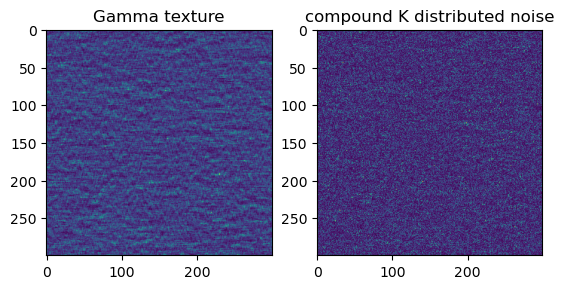

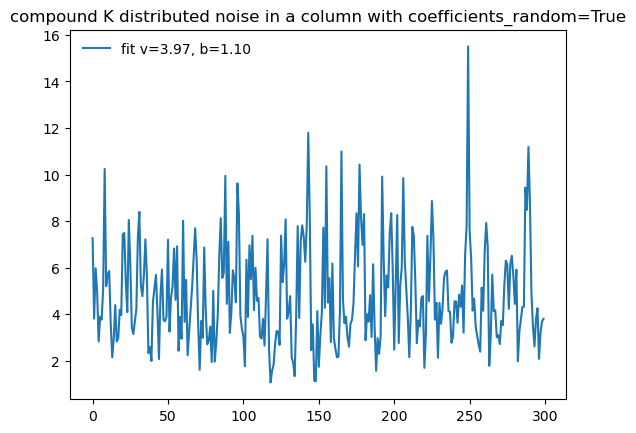

In [ ]:


class KField():
    def __init__(self, img_w=300, img_h=300, gamma_shape=5, coefficients_random=False):
        self.img_w      = img_w
        self.img_h      = img_h
        self.gamma_shape= gamma_shape
        self.coefficients_random = coefficients_random

        xs = np.linspace(10, img_h, num=img_w, endpoint=True)  # avoid the 0,0 start point
        ys = np.linspace(10, img_h, num=img_w, endpoint=True)
        XS, YS = np.meshgrid(xs, ys)

        # Generate the correlated Gamma distribution in random filed(2-dimensional)
        Gwn_field = np.random.normal(loc=0, scale=1, size=(img_h, img_w))
        
        self.gamma_field_acf = 1 + np.exp(-(XS + YS)/10) * np.cos(np.pi * YS/8)/gamma_shape  # eq(69) of Tough_JPD_1999
        
        if coefficients_random is False: # integration over the linear spaced samples, this is the approach in Ward's book
            x = np.linspace(-4, 4, 2048)
            eta = mnlt(x, v)
            coeffs_field = coeff_acf_polyn(x, eta, max_order=2)
        else: # integration over the random samples, this is tha approach in MKCF-TBD
            gamma_cdf_inv_field = mnlt(Gwn_field, v)
            coeffs_field = coeff_acf_polyn(Gwn_field, gamma_cdf_inv_field, max_order=2)

        # print('using [-4,4] gaussian mapping\n', coeffs)
        #coeffs_field = coeff_acf_polyn(Gwn_field, gamma_cdf_inv_field, max_order=2)
        coeffs_field = np.array(coeffs_field) / coeffs_field[-1]
        print(coeffs_field)
        self.gaussian_field_acf = solve_acf_polyn(self.gamma_field_acf, coeffs_field)
        # fig, axs = plt.subplots(1,2)
        # axs[0].imshow(self.gamma_field_acf)
        # axs[0].set_title('Gamma field acf')
        # axs[1].imshow(np.abs(self.gaussian_field_acf))
        # axs[1].set_title('Gaussian field acf')
        # plt.show()
    def generate_K_distributed_noise_fast(self):
        '''
            K distributed noise in fast computing. Regard the gaussian_field_acf is unchanged for all the white noise.
            w(z) = complex gaussian spekcle w^{*}(z)*sqrt(gamma(z))
            amplitude a(z) = |w(z)| is K-distributed noise based on Brekke_IJOE_2010 sec.IV background simulation
            :param gamma_shape:
            :return:
            '''
        v = self.gamma_shape  # gamma shape parameter of the texture

        height, width = self.gamma_field_acf.shape[:2]
        Gwn_field = np.random.normal(loc=0, scale=1, size=(height, width))

        # Generate Gamma Process in the field.
        F_Gw_field = fft2(Gwn_field)  # Frequence domain's white noise in field
        F_Grc_field = fft2(self.gaussian_field_acf)  # Frequence domain's colored Gaussian noise. Gaussian process in field
        G_Gga_field = fft2(self.gamma_field_acf)
        Gcn_field = np.real(ifft2(F_Gw_field * np.sqrt(F_Grc_field)))  # GP samples
        Gan_field = mnlt(Gcn_field, v=v)  # mapping Gp samples in field to the Gamma samples in  field

        assert (np.sum(Gan_field == np.inf)) == 0
        assert (np.sum(Gan_field == np.nan)) == 0
        Gpn_field = self.generate_correlated_Gaussian_via_expdecay()
        CKn_field = Gpn_field * np.sqrt(Gan_field)  # step 7 of Bekker_IJOE in Sec.IV.A
 
        Ckn_field_am = np.abs(CKn_field)
        
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(Gan_field)
        axs[0].set_title('Gamma texture')
        axs[1].imshow(Ckn_field_am)
        #plt.imshow(Ckn_field_am)
        axs[1].set_title('compound K distributed noise')
        plt.figure()
        samples = Gan_field[:,10]
        fit_alpha, fit_loc, fit_beta = stats.gamma.fit(samples, scale=0.9)
        plt.plot(Gan_field[:,10], label=f'fit v={fit_alpha:.2f}, b={fit_beta:.2f}')
        plt.legend(loc='best', frameon=False)
        plt.title('compound K distributed noise in a column with coefficients_random=%s' % self.coefficients_random)
        plt.show()
        return Ckn_field_am, Gan_field

    def generate_correlated_Gaussian_via_expdecay(self):
        '''
        Generate correlated Gaussian via exponentially decayed noise
        :return:
        '''
        M = 300  # Size of the 1D grid
        L = 10   # Physical size of the grid
        dx = L / M  # Sampling period
        fs = 1 / dx  # Sampling frequency
        df = 1 / L  # Spacing between frequency components
        #f = np.linspace(-fs / 2, fs / 2, num=M, endpoint=False)

        # To check the Power Spectral Density (psd) of the white noise, need to repeat more times.
        # and compute the average psd. The psd of white noise is constant in Frequency domain.

        Gwn = np.random.normal(loc=0, scale=1, size=(M,M))
        F_Gw = fft2(Gwn)
        fx = np.linspace(0.1, fs, num=M, endpoint=True)
        fy = np.linspace(0.1, fs, num=M, endpoint=True)
        Fx, Fy = np.meshgrid(fx,fy)
        DFs    = np.sqrt(Fx**2+Fy**2)

        a = 1
        #f[0] = f[1]  # change the first zero elements to the next neighbour
        F_Rc = a * (DFs ** (-1 * 0.6))
        Gpn = ifft2(F_Gw*np.sqrt(F_Rc))
        return Gpn
v = 5
np.random.seed(1)
kfield_clutter = KField(gamma_shape=v, coefficients_random=False)
Ckn_field_am, Gan_field = kfield_clutter.generate_K_distributed_noise_fast()
np.random.seed(1)
kfield_clutter = KField(gamma_shape=v, coefficients_random=True)
Ckn_field_am, Gan_field = kfield_clutter.generate_K_distributed_noise_fast()

## Reference
[Tough_JPD_1999]R. J. A. Tough and K. D. Ward, “The correlation properties of gamma and other non-gaussian processes 
generated by memoryless nonlinear transformation,” J. Phys. D; Appl Phys, vol. 32, pp. 3075–3084, 1999.

[Ward_Book_2006] K.Ward, Robert Tough, Simon Watts.  Sea Clutter Scattering, the K Distribution and Radar Performance, IET

[Brekke_IJOE_2010]E. Brekke, O. Hallingstad and J. Glattetre, "Tracking Small Targets in Heavy-Tailed Clutter Using Amplitude Information," in IEEE Journal of Oceanic Engineering, vol. 35, no. 2, pp. 314-329, April 2010.

[MKCF-TBD_TAES] Y. Zhou, H. Su, S. Tian, X. Liu and J. Suo, "Multiple-Kernelized-Correlation-Filter-Based Track-Before-Detect Algorithm for Tracking Weak and Extended Target in Marine Radar Systems," in IEEE Transactions on Aerospace and Electronic Systems, vol. 58, no. 4, pp. 3411-3426, Aug. 2022.

